# Filter maximisation

In this notebook we will develop a set of functions that allow you to see what images maximise filters inside the network. Much of the notebok here is based on the [How convolutional networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) blog post, but we have adapted the code to work with tensorflow, rather than straight keras.

You should be able to take these sets of functions and reuse them for your own problems.

In [75]:
import tensorflow as tf
from tqdm import tqdm_notebook
import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from skimage.color import rgb2grey
import cv2

## Build a model that outputs intermediate filter values

To do filter maximisation we need to have models that output the values of filters in the middile of the network as information flows through. To do this we 

* Get the names of the intermediate convolutional layers
* Build a new model where every convoutional layer is also an output layer

In [3]:
def make_activation_model(model):
    """Make an 'activation model' for the pre-trained model
    
    Takes an existing, pre-trained model and finds all convolution layers.
    Then creates a new model where every convolutional layer is also an 
    output layer.
    
    Args:
        model: a pre-trained model with convolutional layers
    Returns:
        an activation model where all convolutional layers are also output layers
    """
    layers = [layer for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in layers]
    layer_names = [layer.name for layer in layers]
    
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    return activation_model

## Find an image to maximise the filter activity

* Take the gradient of the input image with respect to filter's activity 
* Update the input image to maximise this derivative 

In [4]:
def maximize_filter_activation(input_img, activation_model, layer_index, filter_index, n_iter=20, step=1):
    """Maximize the activation of a given filter
    
    Based on the example code for Keras by F. Chollet:
    https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
    
    Args:
        input_img: input image to maxmize the activation for. This is usually gaussian random noise. 
        activation_model: an activation model to use to sample filters from
        layer: layer to maximize given filter for.
        layer_index: index of the layer to maximize.
        
    Returns:
        Maximized output for the given filter of shape (num filters, h, w, channels)
        loss for that filter
    """
    input_img_data = tf.constant(input_img, dtype=tf.float32)
    for i in range(n_iter):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            loss = tf.math.reduce_mean(activation_model(input_img_data)[layer_index][:, :, :, filter_index])
            # compute the gradient of the input picture wrt this loss
            grads = tape.gradient(loss, input_img_data)
            # normalization trick: we normalize the gradient
            grads /= (tf.math.sqrt(tf.math.reduce_mean(tf.math.square(grads))) + 1e-5)
            input_img_data += (grads * step)

    return input_img_data, loss

## Random filter sampling

Here we take the filters from the layer `layer_index` and take a random sample of the filters and maximise the imput images with respect to them.

In [5]:
def random_filter_samples(input_img, activation_model, layer_index, n_samples=10, **kwargs):
    """Maximize the activation for a random sample of filters
    
    Args:
        input_img: input image to maxmize the activation for. This is usually gaussian random noise. 
        activation_model: an activation model to use to sample filters from
        layer_index: index of the layer to maximize filters for.
        
    Returns:
        list of maximized activations for a random sample of filters.
    """
    n_filters = activation_model.output_shape[layer_index][-1]
    n_samples = n_filters if n_filters < n_samples else n_samples
    indices = np.random.choice(n_filters, n_samples, replace=False)
    outputs = []
    for filter_index in indices:
        output = maximize_filter_activation(input_img, activation_model, layer_index, filter_index, **kwargs)
        outputs.append(output[0].numpy())
    return outputs


## Maximum filter sampling

Here we take the filters from the layer `layer_index` and take the `n_samples` filters with the greatest activation values.

In [6]:
def max_filter_samples(input_img, activation_model, layer_index, n_samples=5, limit=32, **kwargs):
    """Get the filters that respond the most to input signals. We get this by seleting the filters with the lowest
    loss as returned by maximize_filter_activation    
    Args:
        input_img: input image to maxmize the activation for. This is usually gaussian random noise. 
        activation_model: an activation model to use to sample filters from
        layer_index: index of the layer to maximize filters for.
        n_select: the top number of filters to return
        
    Returns:
        list of maximized activations for a random sample of filters.
    """
    n_filters = activation_model.output_shape[layer_index][-1]
    indices = range(n_filters)
    if len(indices) > limit:
        indices = range(limit)
    outputs = []
    for filter_index in indices:
        output = maximize_filter_activation(input_img, activation_model, layer_index, filter_index, **kwargs)
        outputs.append([output[0].numpy(), output[1].numpy()])
    outputs = sorted(outputs, key=lambda x: x[1], reverse=True)
    outputs = [o[0] for o in outputs]
    n_samples = n_filters if n_filters < n_samples else n_samples
    return outputs[:n_samples]

## The master function that controls the others

This is the function that you call at the top level. You need to tell it the model to feed, the input image, which layers of the network you want to look at, whether to sample randomly or maximum activation filters and how many filters to look at in each layer.

In [25]:
def sample_model_filters(model, input_img, layers=[], mode='random', n_samples=5, **kwargs):
    """Sample filters from a model
    
    This will randomly sample filters from the model and
    maximise the activation of that filter using the given input image/
    
    Args:
        model: input model to sample filters from
        input_img: the input image to use to maximise filter activation.
            Must match the input shape expected by the model.
        layers: the index of the layers to sample
    
    Returns:
        list of samples of maximized input for filters form each layer of the model
    """
    activation_model = make_activation_model(model)
    model_layer_outputs = [ ]
    if layers == []:
        layers = range(len(activation_model.output_shape))
    for layer_index in tqdm_notebook(layers):
        if mode == 'random':
            output = random_filter_samples(input_img, activation_model, layer_index, n_samples,  **kwargs)
        elif mode == 'max':
            output = max_filter_samples(input_img, activation_model, layer_index, n_samples, **kwargs)
        model_layer_outputs.append(output)
    return model_layer_outputs

## Set up the network and the image

* Set up a random image as input, you can choose the dimensions.
* Load a pre-trained model from keras - we will use `VGG16` with the `imagenet` weights

In [26]:
img_width = 64
img_height = 64
model = VGG16(include_top=False, weights='imagenet')
# we start from a gray image with some noise
input_img = np.random.random((1, img_width, img_height, 3)) * 20 + 128.

## Run the maximisation procedure

In the first instance let's run the first, fifth and eigth layers and sample 3 filters from each. We can see how the filters develop through the network. We will run the image maximisation for 20 steps with a scaling of steps of 5.

In [36]:
model_layer_outputs = sample_model_filters(model, input_img, layers=[0, 4, 7], mode='random', n_samples=3, n_iter=40, step=5)

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Visualise the results

Using `ipython_widgets` we will look at the outputs of the maximisation.

In [37]:
@widgets.interact(layer_outputs=widgets.fixed(model_layer_outputs), 
                  index=widgets.Select(options=range(len(model_layer_outputs))))
def plot_filters(layer_outputs, index):
    outputs = layer_outputs[index]
    n_filters = len(outputs)

    fig, axes = plt.subplots(n_filters, 1, figsize=(20, 18))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for ax, l in zip(axes.flatten(), outputs):
        img = rgb2grey(l)
        ax.imshow(np.squeeze(img), cmap='Blues', interpolation='gaussian')
        ax.axis('off')

interactive(children=(Select(description='index', options=(0, 1, 2), value=0), Output()), _dom_classes=('widge…

## Exercises

* Play around with looking at different layers.
* Try feeding an actual image rather than a random array, what are the results?

In [88]:
def preprocess_image(image_path, size=0.3):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = cv2.resize(img, (int(img.shape[1]*size), int(img.shape[0]*size)))
    img = np.expand_dims(img, axis=0)

    return img

In [101]:
base_image_path = tf.keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
img = preprocess_image(base_image_path)
model_layer_outputs = sample_model_filters(model, img, layers=[7], mode='random', n_samples=1, n_iter=20, step=5)

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


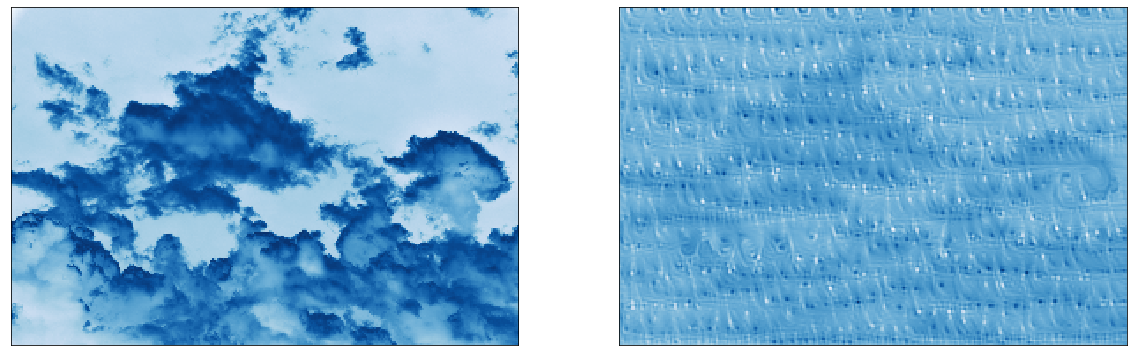

In [102]:
imgg = rgb2grey((model_layer_outputs[0][0]))
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0] .imshow(np.squeeze(rgb2grey(img)), cmap='Blues')
ax[1].imshow(np.squeeze(imgg), cmap='Blues')
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])